In [4]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syste

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import missingno as msno

In [6]:
from datasets import load_dataset

ds = load_dataset("jahjinx/IMDb_movie_reviews")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.24k [00:00<?, ?B/s]

IMDB_train.csv:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

IMDB_validation.csv:   0%|          | 0.00/5.23M [00:00<?, ?B/s]

IMDB_test.csv:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/36000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 36000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})

In [8]:
labels = ds["train"]["label"]

In [9]:
df = ds['train'].to_pandas()
df = df[:700]
df.sample(5)

,text,label
645,"When I saw the first preview for this, I nearl...",1
655,Holy freaking God all-freaking-mighty. This mo...,0
686,I have no idea as to which audience director G...,0
334,If you are planning to schedule your program f...,0
537,I remember seeing this movie 34 years ago and ...,1


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = 'distilbert/distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenized_texts = tokenizer(ds['train']['text'])
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [11]:
def tokenize(sample):
  return tokenizer(sample['text'], truncation=True)

In [12]:
tokenized_dataset = ds.map(tokenize, batched=True)

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    metric_for_best_model="f1",
    num_train_epochs=2,
    learning_rate=0.00002,
    report_to="none"
)

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [15]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00


In [17]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [19]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [20]:
import torch

In [21]:
torch.cuda.is_available()

True

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
device

'cuda'

In [24]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.202700,0.186233,0.931745
2,0.123600,0.249840,0.933000


TrainOutput(global_step=4500, training_loss=0.17653551398383246, metrics={'train_runtime': 3509.9023, 'train_samples_per_second': 20.513, 'train_steps_per_second': 1.282, 'total_flos': 9435358894226112.0, 'train_loss': 0.17653551398383246, 'epoch': 2.0})

In [26]:
trainer.evaluate()

{'eval_loss': 0.24984018504619598,
 'eval_f1': 0.9330003350083753,
 'eval_runtime': 60.1462,
 'eval_samples_per_second': 66.505,
 'eval_steps_per_second': 4.157,
 'epoch': 2.0}

In [27]:
predictions = trainer.predict(tokenized_dataset["test"])

In [28]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5044
           1       0.94      0.93      0.93      4956

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



Text(0.5, 1.0, 'Confusion Matrix')

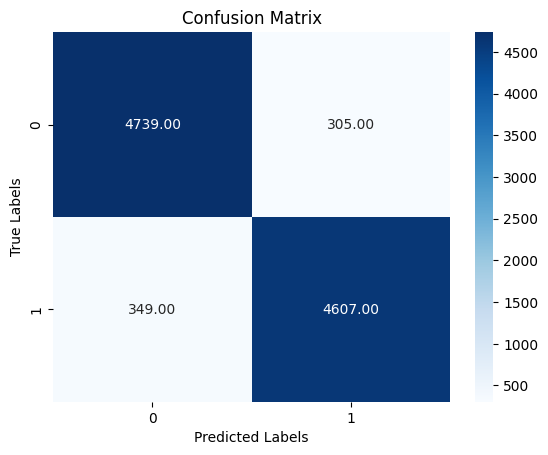

In [31]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")